In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from pylab import rcParams

In [2]:
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

In [3]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split

In [4]:
import warnings
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 16, 10

In [5]:
def get_report(train_values, train_pred, valid_values, valid_pred):
    print('\nTRAIN\n\n' + classification_report(train_values, train_pred))
    print('VALID\n\n' + classification_report(valid_values, valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(valid_values, valid_pred))

In [6]:
TRAIN_DF_PATH = '../lss11_web07/course_project_train.csv'
TEST_DF_PATH = '../lss11_web07/course_project_test.csv'

In [7]:
train_frame = pd.read_csv(TRAIN_DF_PATH)
test_frame = pd.read_csv(TEST_DF_PATH)

In [8]:
# знакомство с обучающим датасетом на примере первой (одной) записи.
train_frame.loc[0]

Home Ownership                            Own Home
Annual Income                             482087.0
Years in current job                           NaN
Tax Liens                                      0.0
Number of Open Accounts                       11.0
Years of Credit History                       26.3
Maximum Open Credit                       685960.0
Number of Credit Problems                      1.0
Months since last delinquent                   NaN
Bankruptcies                                   1.0
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                     99999999.0
Current Credit Balance                     47386.0
Monthly Debt                                7914.0
Credit Score                                 749.0
Credit Default                                   0
Name: 0, dtype: object

In [9]:
# знакомство с рабочим (обучающим) датасетом на примере нескольких записей
train_frame.head(6)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1


In [10]:
train_frame.shape

(7500, 17)

In [11]:
train_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### 3. Обработка пропусков

In [12]:
(len(train_frame) - train_frame.count())[(len(train_frame) - train_frame.count()) != 0]

Annual Income                   1557
Years in current job             371
Months since last delinquent    4081
Bankruptcies                      14
Credit Score                    1557
dtype: int64

In [13]:
train_frame['Years in current job'][train_frame['Years in current job'].isna()] = \
            train_frame['Years in current job'].value_counts().index[0]

In [14]:
# train_frame.loc[train_frame.Bankruptcies.isna(), 'Bankruptcies']
train_frame.Bankruptcies[train_frame.Bankruptcies.isna()] = train_frame.Bankruptcies.mode()[0]
train_frame.Bankruptcies = train_frame.Bankruptcies.astype('category')

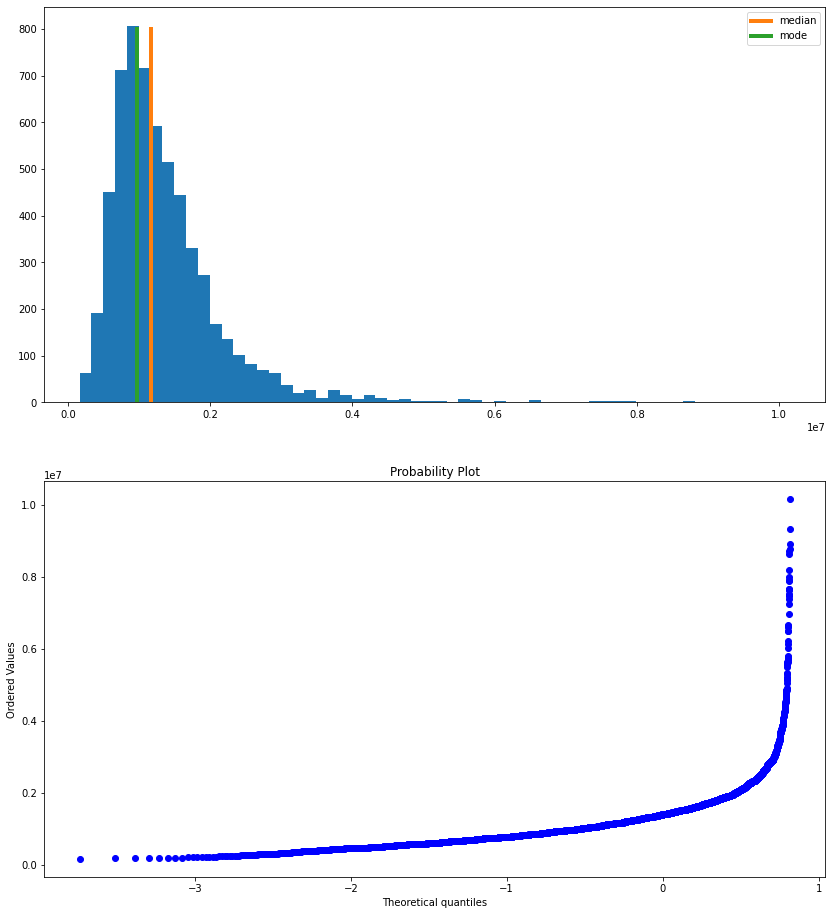

In [15]:
# train_frame['Annual Income'].value_counts()
from scipy import stats
plt.figure(figsize=(14, 16))
plt.subplot(211)
plt.hist(train_frame['Annual Income'], bins=60)
plt.plot([train_frame['Annual Income'].median()] * 6, np.linspace(0, 800, 6), label='median', linewidth=4)
plt.plot([train_frame['Annual Income'].mode()[0]] * 6, np.linspace(0, 800, 6), label='mode', linewidth=4)
plt.legend()
plt.subplot(212)
stats.probplot(train_frame['Annual Income'], dist='norm', plot=plt)
plt.show()

In [16]:
frame_2 = train_frame.loc[train_frame['Credit Score'].isna(), ['Annual Income', 'Credit Score']]
frame_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1557 entries, 5 to 7499
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Annual Income  0 non-null      float64
 1   Credit Score   0 non-null      float64
dtypes: float64(2)
memory usage: 36.5 KB


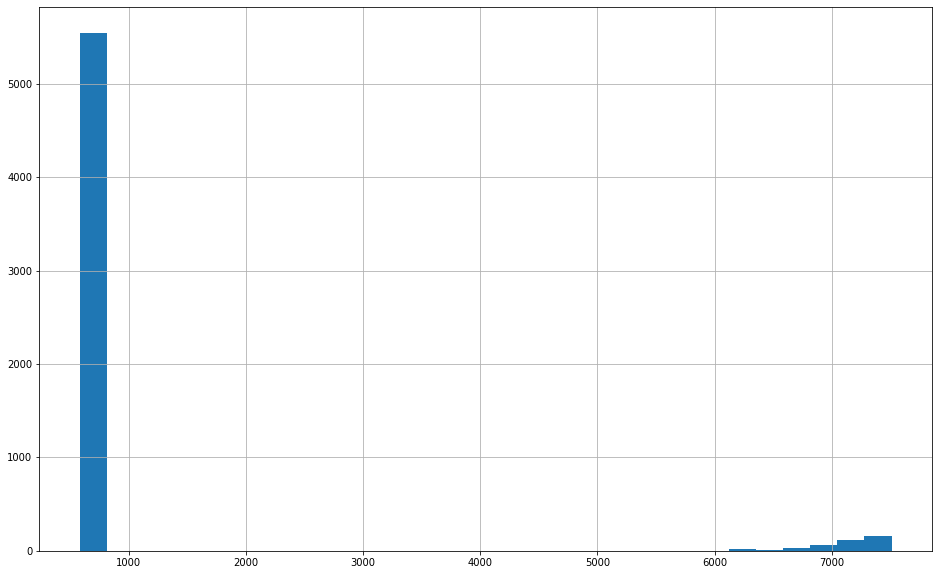

In [17]:
train_frame['Credit Score'].hist(bins=30, density=False)
plt.show()

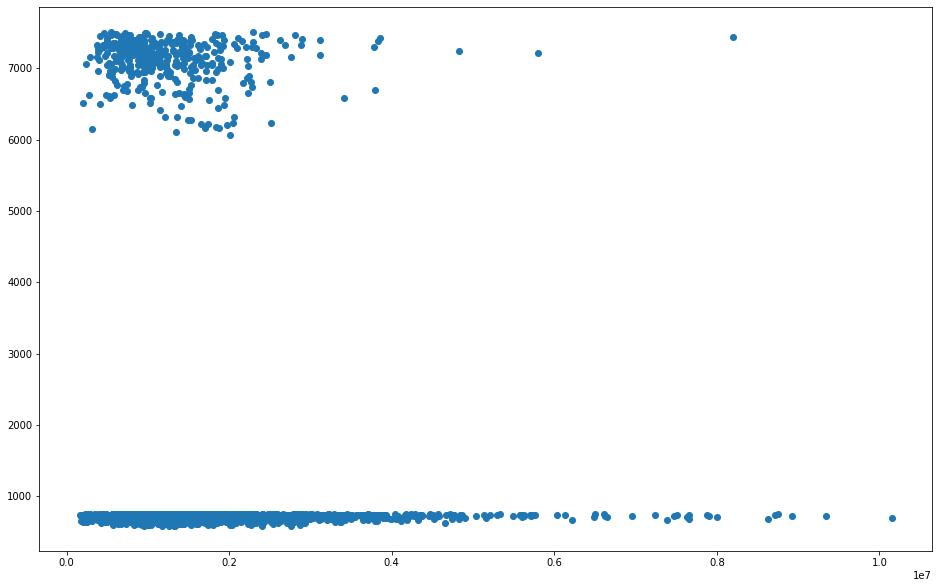

In [18]:
plt.scatter(train_frame['Annual Income'], train_frame['Credit Score'])
plt.show()

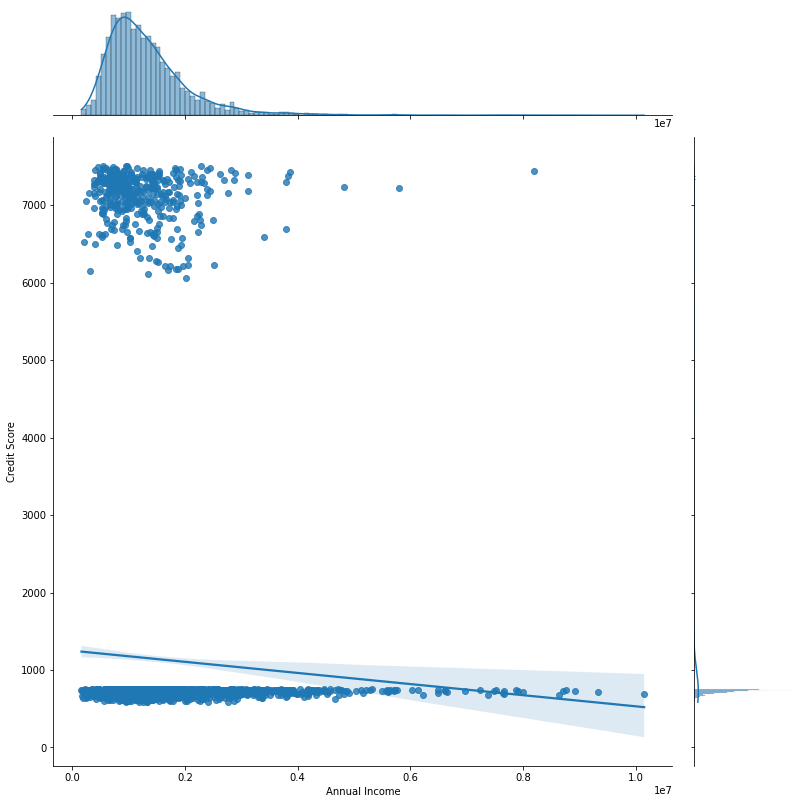

In [19]:
grid = sns.jointplot(train_frame['Annual Income'], train_frame['Credit Score'], kind='reg')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

In [20]:
train_frame.loc[train_frame['Annual Income'].isna(), 'Annual Income'] = \
            train_frame['Annual Income'].mode()[0]
train_frame.loc[train_frame['Credit Score'].isna(), 'Credit Score'] = \
            train_frame['Credit Score'].mode()[0]
train_frame['Months since last delinquent']\
                                    [train_frame['Months since last delinquent'].isna()] = \
            train_frame['Months since last delinquent'].mode()[0]

In [21]:
(len(train_frame) - train_frame.count())[(len(train_frame) - train_frame.count()) != 0]

Series([], dtype: int64)

In [22]:
frame_3 = train_frame.loc[~train_frame['Months since last delinquent'].isna()]
series_1 = (len(frame_3)-frame_3.count())
series_1[(len(frame_3)-frame_3.count()) != 0]

Series([], dtype: int64)

<function matplotlib.pyplot.show(close=None, block=None)>

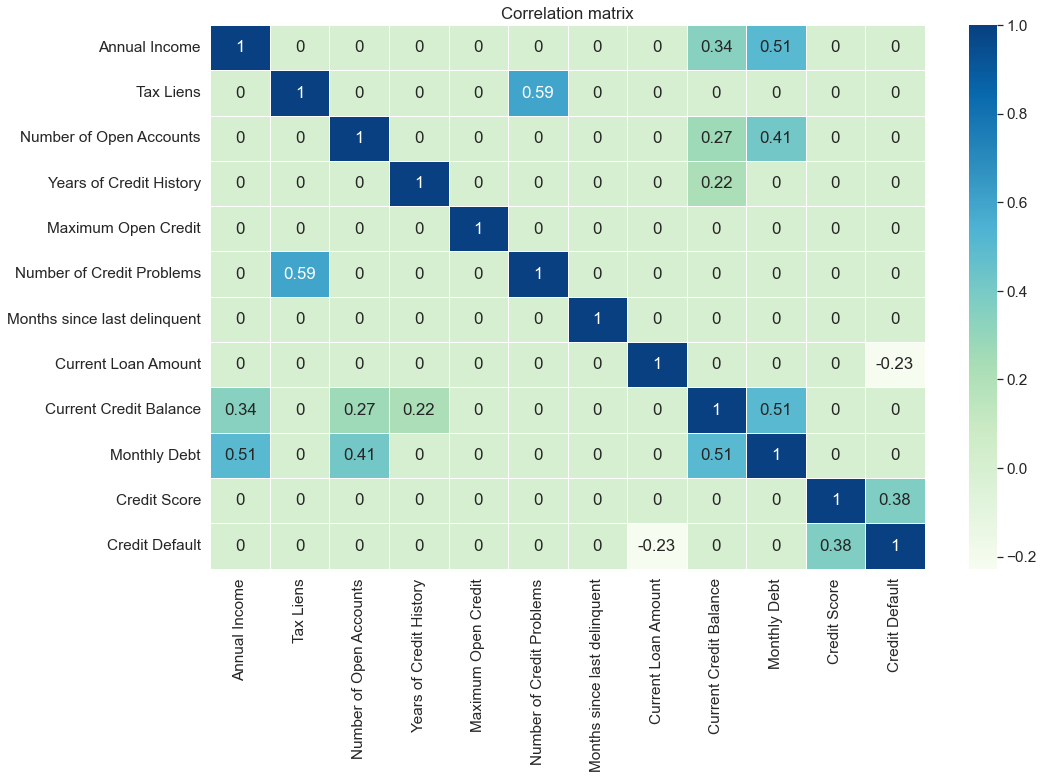

In [23]:
# сделаем анализ коррекляций для фрейма данных без пропусков в признаке 'Months since ...'
corr_matrix = np.round(frame_3.corr(), 3)
corr_matrix[np.abs(corr_matrix) < .2] = 0.0
sns.set(font_scale=1.4)
sns.heatmap(corr_matrix, annot=True, linewidth=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

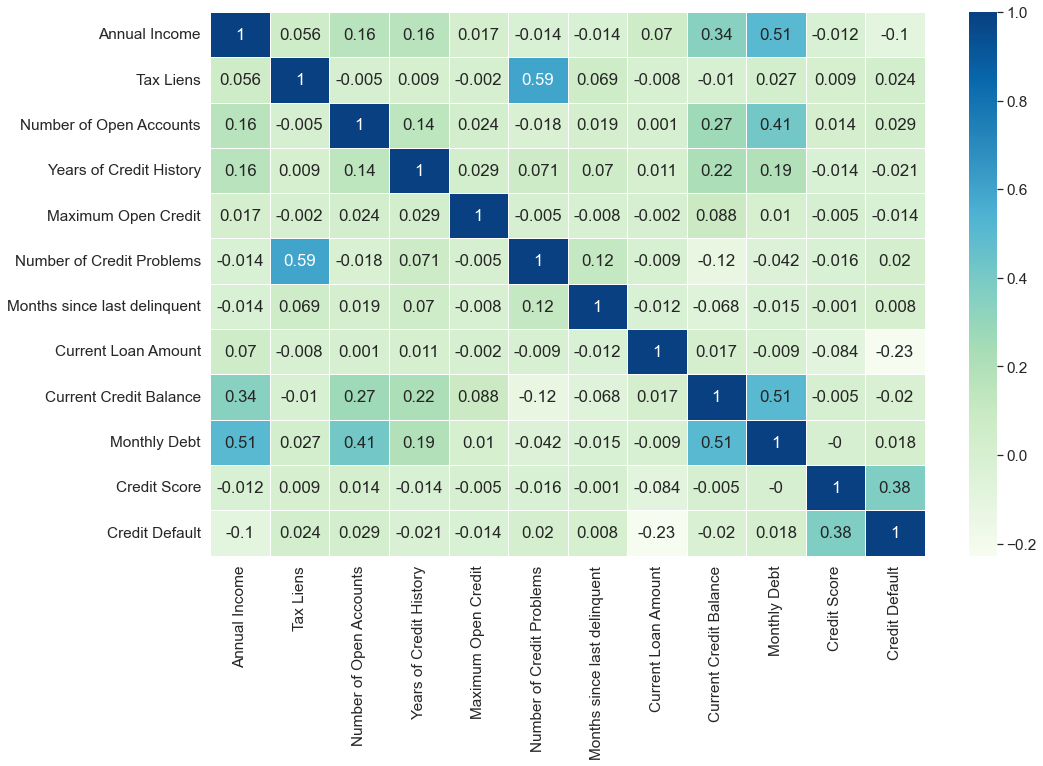

In [24]:
frame_4 = train_frame[~train_frame['Annual Income'].isna()]
# frame_4
sns.heatmap(frame_4.corr().round(3), annot=True, linewidth=.6, cmap='GnBu')
plt.show


### 4. Анализ данных

###### Обзор значений категориальных признаков

In [25]:
for clmn in train_frame.select_dtypes(include='object').columns:
    print(str(clmn) + '\n\n' + str(train_frame[clmn].value_counts()) + '\n' + '*' * 12 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
************

Years in current job

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
************

Term

Short Term    5556
Long Term     1944
Name: Term, dtype: int64
************



_Поля (признаки): 'Term' и 'Home Ownership' напрашиваются чтобы сделать из них dammy переменные в следствии их малого количества уникальных значений. Признак 'Years in current job' возможно преобразовать в числовой тип int по ранговой (ординарной) шкале. А признак 'Purpose' можно попробовать преобразовать в 2, 3 или 4 dummy-переменные и посмотреть их корреляцию с другими признаками._

###### Построение новых признаков (и изменение существующих)

In [26]:
for clm in train_frame.select_dtypes(include=float).columns:
    print(str(clm) + '\n\n' + str(train_frame[clm].value_counts()) + '\n' + '*' * 12 + '\n\n')

Annual Income

969475.0     1561
1043651.0       4
1058376.0       4
1161660.0       4
1338113.0       4
             ... 
1272316.0       1
712082.0        1
695476.0        1
678889.0        1
402192.0        1
Name: Annual Income, Length: 5478, dtype: int64
************


Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
************


Number of Open Accounts

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
31.0      6
34.0      2
37.0      2
43.0      1
41.0      1
38.0      1
35.0      1
42.0      1
Name: Number of Open Accounts, dtype: int64
************


Years of Credit Hist

In [27]:
# построение на основе 'Year in current job' нового категориального признака
lst_1 = list(train_frame['Years in current job'].value_counts().index.sort_values())
train_frame['Years in current job_to_cat'] = \
    train_frame['Years in current job'].map(dict(zip(lst_1, [1, 10, 2, 3, 4, 5, 6, 7, 8, 9, 0])))
train_frame['Years in current job_to_cat'] = \
                train_frame['Years in current job_to_cat'].astype('category')

In [28]:
# Обработка признака 'Home Ownership'
# pd.get_dummies(train_frame['Home Ownership'], prefix='HO')
train_frame = \
    pd.concat([train_frame, pd.get_dummies(train_frame['Home Ownership'], prefix='HO')], axis=1)
lst_2 = ['HO_Have Mortgage', 'HO_Home Mortgage', 'HO_Own Home', 'HO_Rent']
train_frame = train_frame.astype(dict(zip(lst_2, ['category'] * len(lst_2))))

In [29]:
# Работа с признаком 'Term'
train_frame['Term_to_cat'] = train_frame['Term'].map({'Short Term': 1, 'Long Term': 0})
train_frame['Term_to_cat'] = train_frame['Term_to_cat'].astype('category')

In [30]:
# Создание нового категориального признака на основе Bankruptcies
train_frame['Bankruptcies_cat'] = 0
train_frame['Bankruptcies_cat'][train_frame.Bankruptcies != 0] = 1
train_frame['Bankruptcies_cat'] = train_frame['Bankruptcies_cat'].astype('category')

In [31]:
len(train_frame['Number of Open Accounts'].unique()), \
train_frame['Number of Open Accounts'].min(), \
train_frame['Number of Open Accounts'].max(), train_frame['Number of Open Accounts'].dtype
train_frame['Number of Open Accounts'] = train_frame['Number of Open Accounts'].astype('int8')
# train_frame.info()

In [32]:
# Создание нового категориального признака на основе 'Tax Liens'
train_frame['Tax Liens'] = train_frame['Tax Liens'].astype('category')
train_frame['Tax Liens_cat'] = 0
train_frame['Tax Liens_cat'][train_frame['Tax Liens'] != 0] = 1
train_frame['Tax Liens_cat'] = train_frame['Tax Liens_cat'].astype('category')
# train_frame['Tax Liens_cat'].value_counts()
# train_frame.info()

In [33]:
# Number of Credit Problems
train_frame['Number of Credit Problems'] = \
                train_frame['Number of Credit Problems'].astype('category')
train_frame['Number of Credit Problems_cat'] = 0
train_frame['Number of Credit Problems_cat'][train_frame['Number of Credit Problems'] != 0] = 1
train_frame['Number of Credit Problems_cat'] = \
                train_frame['Number of Credit Problems_cat'].astype('category')
# train_frame.info()

In [34]:
# С признаком Purpose предлагаю поступить так. Поскольку преобладающее значение (80%) 'debt consolidation'
# предлагаю создать на основе этого признака dummy переменную, где значение 'debt consolidation' будет 
# соответствовать 1, остальные значеничя в Purpose 0.
train_frame.loc[train_frame['Purpose'] == 'debt consolidation', 'Purpose_dummi'] = 1
train_frame.loc[train_frame['Purpose'] != 'debt consolidation', 'Purpose_dummi'] = 0
train_frame.Purpose_dummi = train_frame['Purpose_dummi'].astype('category')
# train_frame.info()

In [35]:
# посмотрим на описательную статистику для числовых признаков.
num_feat = list(train_frame.select_dtypes(include=float).columns)
train_frame[num_feat].describe()

,Annual Income,Years of Credit History,Maximum Open Credit,Months since last delinquent,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,7.500000e+03,7500.000000,7.500000e+03,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000
mean,1.283992e+06,18.317467,9.451537e+05,23.433067,1.187318e+07,2.898332e+05,18314.454133,1065.745733
std,7.695113e+05,7.041946,1.602622e+07,17.906245,3.192612e+07,3.178714e+05,11926.764673,1437.907935
min,1.645970e+05,4.000000,0.000000e+00,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000
25%,9.311330e+05,13.500000,2.792295e+05,14.000000,1.801690e+05,1.142565e+05,10067.500000,718.000000
50%,9.891305e+05,17.000000,4.781590e+05,14.000000,3.095730e+05,2.093230e+05,16076.500000,738.000000
75%,1.499974e+06,21.800000,7.935015e+05,29.000000,5.198820e+05,3.604062e+05,23818.000000,740.000000
max,1.014934e+07,57.700000,1.304726e+09,118.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000


_Судя по статистикам признаки 'Maximum Open Credit', 'Current Loan Amount' и 'Current Credit Balance' имеют особенно большое количество выбросов так что величина стандартного отклонения превышает среднее значение. А поле 'Current Loan Amount' содержит аномальные значения - восемь девяток (встречается 870 раз) тогда как остальные значения распределены более менее равномерно (не чаще 6 раз)._

_Часть числовых признаков имеет довольно большой (широкий) диапазон значений. Требуется выполнить нормировку значений к диапазону (0, 1)_

###### Нормировка значений признаков

In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# plt.hist(train_frame['Annual Income'], bins=60)

# сделаю обработку выбросов позже, здесь проверяю работу объекта
# train_frame[['Annual Income', 'Credit Score']] = \
#             scaler.fit_transform(train_frame[['Annual Income', 'Credit Score']])

In [37]:
# проверка
train_frame[['Annual Income', 'Credit Score']].describe()

,Annual Income,Credit Score
count,7.500000e+03,7500.000000
mean,1.283992e+06,1065.745733
std,7.695113e+05,1437.907935
min,1.645970e+05,585.000000
25%,9.311330e+05,718.000000
50%,9.891305e+05,738.000000
75%,1.499974e+06,740.000000
max,1.014934e+07,7510.000000


###### _попытка обучить модель catboost оказалась провальной, на обучающией выборке r2_score = .72 на валидационной отрицательная ((((_ ######

### 2. Обработка выбросов в числовых признаках

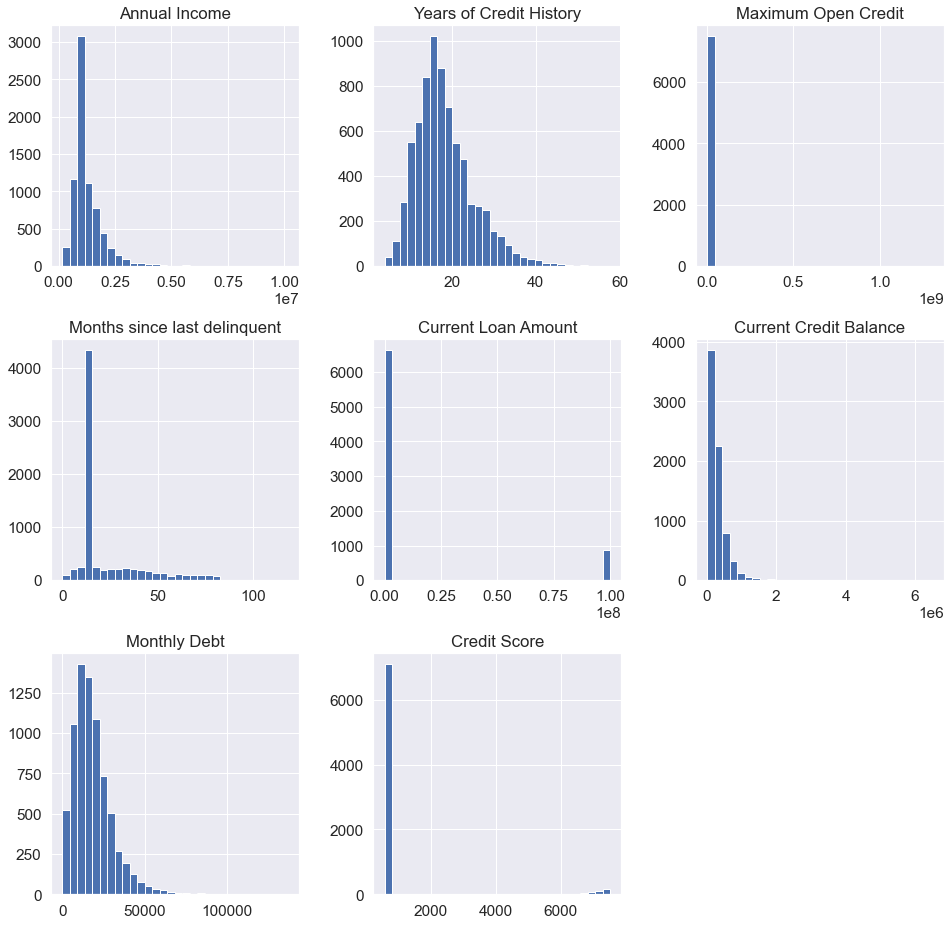

In [38]:
train_frame[num_feat].hist(figsize=(16, 16), bins=30)
plt.show()

_Судя по гистаграммам распределения числовых признаков в большинстве случаев данные имеют выбросы; что требует их устраниния._

In [39]:
def outlier_processing(feat):
        
    '''
    функция для заполнения выбросов за пределами +/-1.5*IQR() значениями медианы по распределению признака
    функция получает аргументом один признак из dataFrame - удаляет из него выбросы и возвращает обработанным
    '''
    
    Q1 = feat.quantile(.25)
    Q2 = feat.median()
    Q3 = feat.quantile(.75)
    IQR = Q3 - Q1
    min_IQR = Q1 - 1.5 * IQR
    max_IQR = Q3 + 1.5 * IQR
    feat[(feat < min_IQR) | (feat > max_IQR)] = Q2
    
    return feat

In [40]:
def IQR(feat):
    ''' Печать квантилей и основанных на них диапазонах для проверки работы функции
        outlier_processing()
    '''
    Q1 = feat.quantile(.25)
    Q2 = feat.median()
    Q3 = feat.quantile(.75)
    IQR = Q3 - Q1
    min_IQR = Q1 - 1.5 * IQR
    max_IQR = Q3 + 1.5 * IQR
    print(f'Q1: {Q1}\nQ2: {Q2}\nQ3: {Q3}\nIQR: {IQR}\nmin_IQR: {min_IQR}\nmax_IQR: {max_IQR}\n')

In [41]:
class FramePreprocessing:
    '''Обработка пропусков и выбросов в датасете'''
    '''А также создание новых фич'''
    def __init__(self):
        '''инициализация атрибутов класса'''
        self.medians = None
        self.modes = None
        pass
    
    def fit(self, dframe):
        '''Расчет статистик для заполнения выбросов и пропусков'''
        self.medians = dframe.median()
        self.modes   = dframe.mode().loc[0]
        pass
    
    def transform(self, dframe):
        '''преобразование данных'''
        
        # ['Years in current job']
        dframe['Years in current job'][dframe['Years in current job'].isna()] = \
                            self.modes['Years in current job']
        lst_1 = list(dframe['Years in current job'].value_counts().index.sort_values())
        dframe['Years in current job_to_cat'] = \
            dframe['Years in current job'].map(dict(zip(lst_1, \
                                                             [1, 10, 2, 3, 4, 5, 6, 7, 8, 9, 0])))
        dframe['Years in current job_to_cat'] = \
                dframe['Years in current job_to_cat'].astype('category')
        
        # Заполнение пропусков в полях ['Annual Income'], ['Credit Score'], 
        # ['Month since last delinquent']
        dframe.loc[dframe['Annual Income'].isna(), 'Annual Income'] = \
            self.modes['Annual Income']
        dframe.loc[dframe['Credit Score'].isna(), 'Credit Score'] = \
            self.modes['Credit Score']
        dframe['Months since last delinquent'][dframe['Months since last delinquent'].isna()] = \
            self.modes['Months since last delinquent']
        
        # Bankrupties
        dframe.Bankruptcies[dframe.Bankruptcies.isna()] = self.modes.Bankruptcies
        dframe['Bankruptcies_cat'] = 0
        dframe['Bankruptcies_cat'][dframe.Bankruptcies != 0] = 1
        dframe.Bankruptcies        = dframe.Bankruptcies.astype('category')
        dframe['Bankruptcies_cat'] = dframe['Bankruptcies_cat'].astype('category')
        
        # Создание нового категориального признака на основе ['Tax Liens']
        dframe['Tax Liens'] = dframe['Tax Liens'].astype('category')
        dframe['Tax Liens_cat'] = 0
        dframe['Tax Liens_cat'][dframe['Tax Liens'] != 0] = 1
        dframe['Tax Liens_cat'] = dframe['Tax Liens_cat'].astype('category')

        # ['Number of Credit Problems']
        dframe['Number of Credit Problems'] = \
                        dframe['Number of Credit Problems'].astype('category')
        dframe['Number of Credit Problems_cat'] = 0
        dframe['Number of Credit Problems_cat'][dframe['Number of Credit Problems'] \
                                               != 0] = 1
        dframe['Number of Credit Problems_cat'] = \
                        dframe['Number of Credit Problems_cat'].astype('category')
        
        # ['Number of Open Accounts']
        mn = dframe['Number of Open Accounts'].min()
        mx = dframe['Number of Open Accounts'].max()
        if   np.iinfo(np.int8).min  < mn and mx < np.iinfo(np.int8).max:
            dframe['Number of Open Accounts'] = dframe['Number of Open Accounts'].astype('int8')
        elif np.iinfo(np.int16).min < mn and mx < np.iinfo(np.int16).max:
            dframe['Number of Open Accounts'] = dframe['Number of Open Accounts'].astype('int16')
        elif np.iinfo(np.int32).min < mn and mx < np.iinfo(np.int32).max:
            dframe['Number of Open Accounts'] = dframe['Number of Open Accounts'].astype('int32')
        elif np.iinfo(np.int64).min < mn and mx < np.iinfo(np.int64).max:
            dframe['Number of Open Accounts'] = dframe['Number of Open Accounts'].astype('int64')

        # обработка признака ['Purpose']
        dframe.loc[dframe['Purpose'] == 'debt consolidation', 'Purpose_dummi'] =1
        dframe.loc[dframe['Purpose'] != 'debt consolidation', 'Purpose_dummi'] = 0
        dframe.Purpose_dummi = dframe.Purpose_dummi.astype('category')
        
        # Работа с признаком ['Term']
        dframe['Term_to_cat'] = dframe['Term'].map({'Short Term': 1, 'Long Term': 0})
        dframe['Term_to_cat'] = dframe['Term_to_cat'].astype('category')
        
        # ['Credit Default'] to np.int8
#         dframe['Credit Default'] = dframe['Credit Default'].astype('int8')
        
        # ----------------------------------------------------------------------
        # ['Home Ownership']
        # создание новых категориальных признаков на основе ['Home Ownership']
        dframe = pd.concat([dframe, pd.get_dummies(dframe['Home Ownership'], prefix='HO')], 
                            axis=1)
        lst_2 = ['HO_Have Mortgage', 'HO_Home Mortgage', 'HO_Own Home', 'HO_Rent']
        dframe = dframe.astype(dict(zip(lst_2, ['category'] * len(lst_2))))
        # почему-то вот этот участок кода и все что после него!!! не отрабатывает, хотя отдельно 
        # работает без проблем??? не понимаю почему; уже нет времени выяснять почему; 
        # и так потратил кучу времени для выяснения этого факта
        # придется отрабатывать его вручную.
        # ----------------------------------------------------------------------

        # dframe.fillna(self.medians, inplace=True)
        
        # return dframe

### 5. Отбор Признаков

In [42]:
trg_feat = 'Credit Default'
obj_feats = train_frame.select_dtypes(include=object).columns.tolist()
cat_feats = train_frame.select_dtypes(include='category').columns.tolist()
num_feats = train_frame.select_dtypes(include=float).columns.tolist() + \
                                                    ['Number of Open Accounts']
# int_feats = train_frame.select_dtypes(include=np.int8).columns.tolist()
for clm in train_frame[num_feats].columns: outlier_processing(train_frame[clm])

train_frame[num_feats] = scaler.fit_transform(train_frame[num_feats])

# train_frame[num_feats].describe()

### 6. Балансировка классов

In [43]:
train_frame['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [44]:
print(f"Доля объектов преобладающего {{0}} класса в выборке: {train_frame['Credit Default'].value_counts()[0]/len(train_frame):.4f}")
print(f"Доля объектов главного {{1}} класса в выборке: {train_frame['Credit Default'].value_counts()[1]/len(train_frame):.4f}")
print(f"Соотношение классов: 1 / {train_frame['Credit Default'].value_counts()[0] / train_frame['Credit Default'].value_counts()[1]:.1f}")

Доля объектов преобладающего {0} класса в выборке: 0.7183
Доля объектов главного {1} класса в выборке: 0.2817
Соотношение классов: 1 / 2.5


_Один класс (объекты нулевого класса) преобладает в выборке более чем в два раза по сравнению с количеством объектов главного {1} класса. Можем констатировать наличие проблемы дисбаланса классов в выборке._

In [45]:
# Добавление записей непреобладающего класса в датасет с помощью метода sample
for i in range(3):
    smpl = train_frame[train_frame['Credit Default'] == 1].sample(1000)
    train_frame = train_frame.append(smpl, ignore_index=True)
#             train_frame['Credit Default'][0] - train_frame['Credit Default'], random_state=29)
train_frame['Credit Default'].value_counts()[1]

5113

Разбиение на train & valid

In [46]:
X = train_frame[num_feats + cat_feats]
y = train_frame[trg_feat]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, \
                                                       test_size=.3, random_state=29)

### 7. Построение и оценка базовых моделей

Логистическая регрессия

K ближайщих соседей

**Бустинговые алгоритмы**

XGBoost

In [47]:
# !pip install XGBoost

Похоже зря я использовал преобразование данные в тип "category"; Этот метод Деревьев Решений пока не поддерживает категориальные данные;
Experimental support for categorical data is not implemented for current tree method yet.

In [48]:
def cat_to_int(df, feats):
    for clm in feats:
        mn = df[clm].astype(np.int64).min()
        mx = df[clm].astype(np.int64).max()
        if   np.iinfo(np.int8).min  < mn and mx < np.iinfo(np.int8).max:
            df[clm] = df[clm].astype(np.int8)
        elif np.iinfo(np.int16).min < mn and mx < np.iinfo(np.int16).max:
            df[clm] = df[clm].astype(np.int16)
        elif np.iinfo(np.int32).min < mn and mx < np.iinfo(np.int32).max:
            df[clm] = df[clm].astype(np.int32)
        else: 
            df[clm] = df[clm].astype(np.int64)
#     return df

In [49]:
cat_to_int(X_train, cat_feats)
cat_to_int(X_valid, cat_feats)

In [50]:
xgb_mod = xgb.XGBClassifier(random_state=29)
xgb_mod.fit(X_train, y_train)
train_pred = xgb_mod.predict(X_train)
valid_pred = xgb_mod.predict(X_valid)
get_report(y_train, train_pred, y_valid, valid_pred)

[18:55:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3778
           1       0.97      0.98      0.97      3572

    accuracy                           0.97      7350
   macro avg       0.97      0.97      0.97      7350
weighted avg       0.97      0.97      0.97      7350

VALID

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1609
           1       0.80      0.88      0.84      1541

    accuracy                           0.83      3150
   macro avg       0.84      0.83      0.83      3150
weighted avg       0.84      0.83      0.83      3150

CONFUSION MATRIX

col

*Вывод: XGBoost показал хорошую метрику на валидационном сете (.81), но явно есть признаки переобучения, т.к. большая разница train/valid (.97/.81); что потребует применения методов борьбы с переобучением.*

LightGBM

CatBoost

*Выводы применения boosting алгоритмов: пристрелочное использования трех алгоритмов бустинга с параметрами по умолчанию показал близкие результаты: .81 (xgb) / .78 (lgbm) / .77 (catb) с признаками переобучения во всех трех случаях.*

### 8. Выбор наилучшей модели, настройка гиперпараметров

Оценка модели lgbm с гиперпараметрами по умолчанию с помощью повторной стратифицированной k-кратной кросс-валидации с тремя повторами и k, равным 10.

**Из рассмотренных бустинговых моделей делаю выбор в пользу XGBoost**

_Модель XGBoost с параметрами по умолчанию выдала несколько лучший результат чем с параметрами полученными с помощью поиска; (попробовал разные диапазоны гиперпараметров, и GridSearch/RandomizedSearch_

### 9. Проверка качества, борьба с переобучением

In [54]:
# финальная модель
fin_mod = xgb.XGBClassifier(random_state=29)
fin_mod.fit(X_train, y_train)
train_pred = fin_mod.predict(X_train)
valid_pred = fin_mod.predict(X_valid)
valid_pred_prob = fin_mod.predict_proba(X_valid)
get_report(y_train, train_pred, y_valid, valid_pred)

[18:58:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3778
           1       0.97      0.98      0.97      3572

    accuracy                           0.97      7350
   macro avg       0.97      0.97      0.97      7350
weighted avg       0.97      0.97      0.97      7350

VALID

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1609
           1       0.80      0.88      0.84      1541

    accuracy                           0.83      3150
   macro avg       0.84      0.83      0.83      3150
weighted avg       0.84      0.83      0.83      3150

CONFUSION MATRIX

col

**_Вывод: попробовал различные значения для параметров регуляризации L1 (reg_alpha) и L2 (reg_lambda): .1, .5, 1, 2, 5; Использование регуляризации не дало сколь-нибудь значимых изменений касательно проблемы переобучения._**

In [55]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

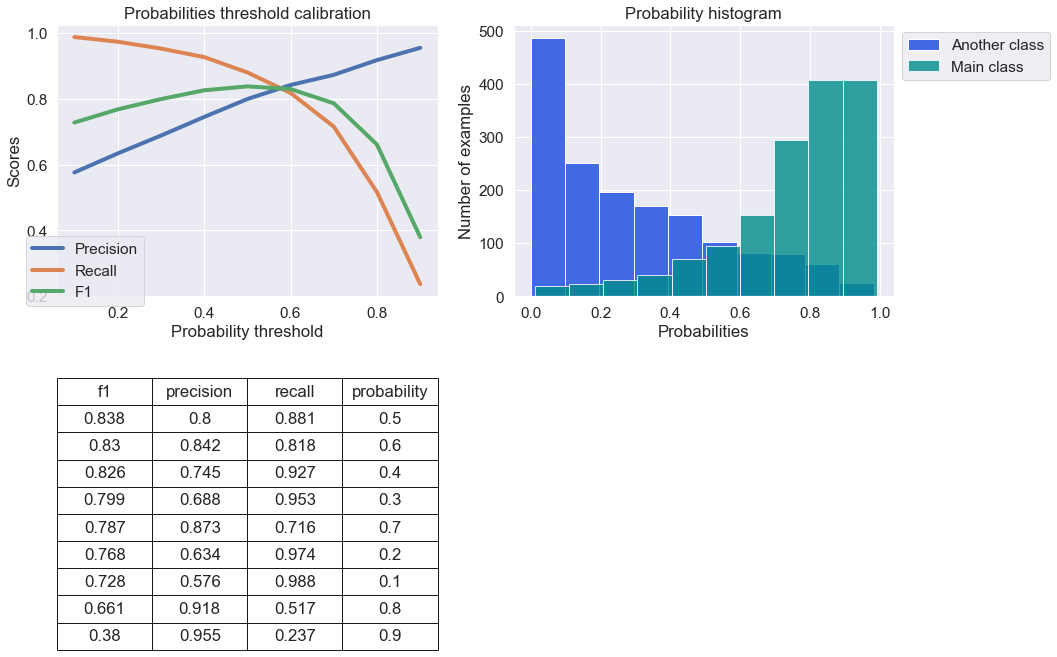

In [56]:
show_proba_calibration_plots(valid_pred_prob[:, 1], y_valid)

**_Как видно по Probability histogram - финальная модель имеет хорошую разделяющую способоность!_**

In [57]:
imp_feats = pd.DataFrame({'feats':X_train.columns, 'imps_val':fin_mod.feature_importances_})\
                    .sort_values('imps_val', ascending=False)
fin_feats_list = imp_feats[:18]['feats'].tolist()
fin_feats_list

['Credit Score',
 'Term_to_cat',
 'Current Loan Amount',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Annual Income',
 'Maximum Open Credit',
 'Current Credit Balance',
 'Monthly Debt',
 'HO_Rent',
 'Years of Credit History',
 'Years in current job_to_cat',
 'HO_Own Home',
 'Number of Open Accounts',
 'HO_Home Mortgage',
 'Tax Liens',
 'Bankruptcies',
 'Purpose_dummi']

**_Вывод: из 22 фичей, 18 признаков полезных (имеют ненулевые значения); из этих 18 - 6 признаков которые были сгенерированы дополнительно._**

In [58]:
def show_feature_importances(df, n_top=None):

    plt.figure(figsize = (20, len(df) * 0.355))
    
    sns.barplot(df['imps_val'], df['feats'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if n_top is not None:
        return df['feats'][:n_top].tolist()

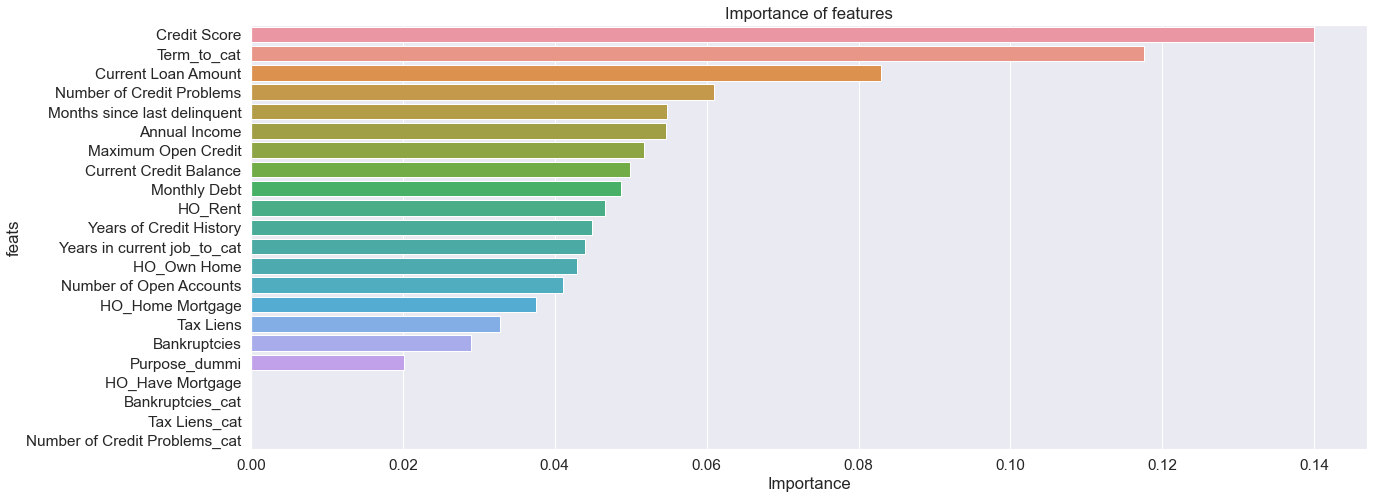

['Credit Score',
 'Term_to_cat',
 'Current Loan Amount',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Annual Income',
 'Maximum Open Credit',
 'Current Credit Balance',
 'Monthly Debt',
 'HO_Rent',
 'Years of Credit History',
 'Years in current job_to_cat',
 'HO_Own Home',
 'Number of Open Accounts',
 'HO_Home Mortgage',
 'Tax Liens',
 'Bankruptcies',
 'Purpose_dummi']

In [59]:
show_feature_importances(imp_feats, n_top=18)

In [60]:
# сохранение модели
import pickle as pkl
with open('../lss11_web07/fin_model.pkl', 'wb') as file:
    pkl.dump(fin_mod, file)

### Формирование предсказаний для тестового датасета

Итак, нужно проделать с тестовым датасетом такие же манипуляции как с обучающим, но есть отличия! (главное не напутать).
1. Заполение пропусков нужно делать по вычисленным характеристикам генеральной совокупности (т.е. по данных обучающей выборки, не тестовой).
2. Обработка выборосов для тестовой выборки не имеет смысла.
3. Нормализация значений числовых признаков делается по данным тестового дата сета (надеюсь я не путаю). Однако для бустинговых алгоритмов не должна быть критичной. (Проверю на train эту гипотезу). Если действительно на train нет разницы в финальной метрике для фреймов обработнных scaler и не обработанных, тогда использовать Scaler не буду.


In [61]:
# проверка на train2
df2 = pd.read_csv(TRAIN_DF_PATH)
preprocessor = FramePreprocessing()
preprocessor.fit(df2)
preprocessor.transform(df2)
df2 = pd.concat([df2, pd.get_dummies(df2['Home Ownership'], prefix='HO')], axis=1)
lst_2 = ['HO_Have Mortgage', 'HO_Home Mortgage', 'HO_Own Home', 'HO_Rent']
df2 = df2.astype(dict(zip(lst_2, ['category'] * len(lst_2))))
df2['Credit Default'] = df2['Credit Default'].astype('int8')
for clm in df2[num_feats].columns: outlier_processing(df2[clm])
for i in range(3):
    smpl = df2[df2['Credit Default'] == 1].sample(1000)
    df2 = df2.append(smpl, ignore_index=True)
# df2['Credit Default'].value_counts()[1]
X2 = train_frame[num_feats + cat_feats]
y2 = train_frame[trg_feat]
cat_to_int(X2, cat_feats)
X2 = X2[fin_feats_list]
X2_train, X2_valid, y2_train, y2_valid = train_test_split(X2, y2, shuffle=True, \
                                                    test_size=.3, random_state=29)
fin2_mod = xgb.XGBClassifier(random_state=29)
fin2_mod.fit(X2_train, y2_train)
train_pred2 = fin2_mod.predict(X2_train)
valid_pred2 = fin2_mod.predict(X2_valid)
get_report(y2_train, train_pred2, y2_valid, valid_pred2)
with open('../lss11_web07/fin2_model.pkl', 'wb') as file:
    pkl.dump(fin2_mod, file)

[18:58:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

TRAIN

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3778
           1       0.97      0.97      0.97      3572

    accuracy                           0.97      7350
   macro avg       0.97      0.97      0.97      7350
weighted avg       0.97      0.97      0.97      7350

VALID

              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1609
           1       0.80      0.88      0.84      1541

    accuracy                           0.83      3150
   macro avg       0.84      0.83      0.83      3150
weighted avg       0.84      0.83      0.83      3150

CONFUSION MATRIX

col

Вывод: код в ячейкен выше - финальная проверка обработки данных перед их применением на тестовом датасете; Работает в целом корректно. Нашел один баг который не смог исправить (в куске кода в class FramePreprocessing - где я формирую dummi-переменные из признака 'Home Ownership');
далее, как показал результат для финальной модели - необходимость в нормализации числовых данных (применения Scaler) отсутстует и не влияет на результат.

### 10. Интерпретация результатов

**_Выводы: на обучающем датасете я получил целевую метрику: .82 - с большим заделом от требуемого.
В итоговый лист отбора значимых признаков возшли 6 признаков, которые я генерировал дополнительно. Я рад что время потраченно на это не прошло даром)))_**

In [62]:
test_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [63]:
# пропуски в тестовом датасете
series_1 = (len(test_frame) - test_frame.count())
series_1[series_1 != 0]
# test_frame.shape

Annual Income                    513
Years in current job              86
Months since last delinquent    1358
Bankruptcies                       3
Credit Score                     513
dtype: int64

In [64]:
test_frame = pd.read_csv(TEST_DF_PATH)
preprocessor.transform(test_frame)
test_frame = pd.concat([test_frame, pd.get_dummies(test_frame['Home Ownership'], prefix='HO')], 
                        axis=1)
lst_2 = ['HO_Have Mortgage', 'HO_Home Mortgage', 'HO_Own Home', 'HO_Rent']
test_frame = test_frame.astype(dict(zip(lst_2, ['category'] * len(lst_2))))
df_test = test_frame[num_feats + cat_feats]
cat_to_int(df_test, cat_feats)
df_test = df_test[fin_feats_list]
test_pred = fin2_mod.predict(df_test)
# я боюсь ошибиться должен ли вывод предсказаний в файл содержать заголовок?
pd.DataFrame(test_pred).to_csv('../lss11_web07/kolesov_predictions.csv', index=False, \
                               encoding='utf-8', sep=',')